In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Load data
df = pd.read_csv('../../data/02_processed_data/cannabis_retail_sales.csv')

# Basic data exploration
print("Dataset Shape:", df.shape)
print("\nColumn Info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())
print("\nUnique values in key columns:")
print(f"Geographic areas: {df['GEO'].nunique()}")
print(f"Date range: {df['REF_DATE'].min()} to {df['REF_DATE'].max()}")
print(f"Adjustment types: {df['Adjustments'].unique()}")


Dataset Shape: (1801, 14)

Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1801 entries, 0 to 1800
Data columns (total 14 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   REF_DATE                                               1801 non-null   object 
 1   GEO                                                    1801 non-null   object 
 2   DGUID                                                  1801 non-null   object 
 3   North American Industry Classification System (NAICS)  1801 non-null   object 
 4   Sales                                                  1801 non-null   object 
 5   Adjustments                                            1801 non-null   object 
 6   UOM                                                    1801 non-null   object 
 7   UOM_ID                                                 1801 non-null   int64  
 8   SCALAR_F

In [20]:
# Convert date column and create time-based features
df['REF_DATE'] = pd.to_datetime(df['REF_DATE'])
df['Year'] = df['REF_DATE'].dt.year
df['Month'] = df['REF_DATE'].dt.month
df['Quarter'] = df['REF_DATE'].dt.quarter

# Convert sales values (already in thousands)
df['Sales_CAD'] = df['VALUE'] * 1000  # Convert to actual CAD values

# Create geographic hierarchy based on GEO column structure
def categorize_geography(geo):
    if geo == 'Canada':
        return 'National'
    elif ',' in geo:
        return 'City'
    else:
        return 'Province'

def extract_province(geo):
    if geo == 'Canada':
        return 'Canada'
    elif ',' in geo:
        return geo.split(',')[1].strip()
    else:
        return geo

def extract_city(geo):
    if ',' in geo:
        return geo.split(',')[0].strip()
    else:
        return None

# Apply geographic categorization
df['Level'] = df['GEO'].apply(categorize_geography)
df['Province'] = df['GEO'].apply(extract_province)
df['City'] = df['GEO'].apply(extract_city)

print("Data preprocessing completed!")
print(f"Date range: {df['REF_DATE'].min().strftime('%Y-%m')} to {df['REF_DATE'].max().strftime('%Y-%m')}")
print(f"\nGeographic breakdown:")
print(df['Level'].value_counts())
print(f"\nSample of geographic entries:")
for level in ['National', 'Province', 'City']:
    sample = df[df['Level'] == level]['GEO'].iloc[0] if len(df[df['Level'] == level]) > 0 else 'None'
    print(f"{level}: {sample}")


Data preprocessing completed!
Date range: 2018-10 to 2025-08

Geographic breakdown:
Level
Province    921
City        714
National    166
Name: count, dtype: int64

Sample of geographic entries:
National: Canada
Province: Newfoundland and Labrador
City: Montréal, Quebec


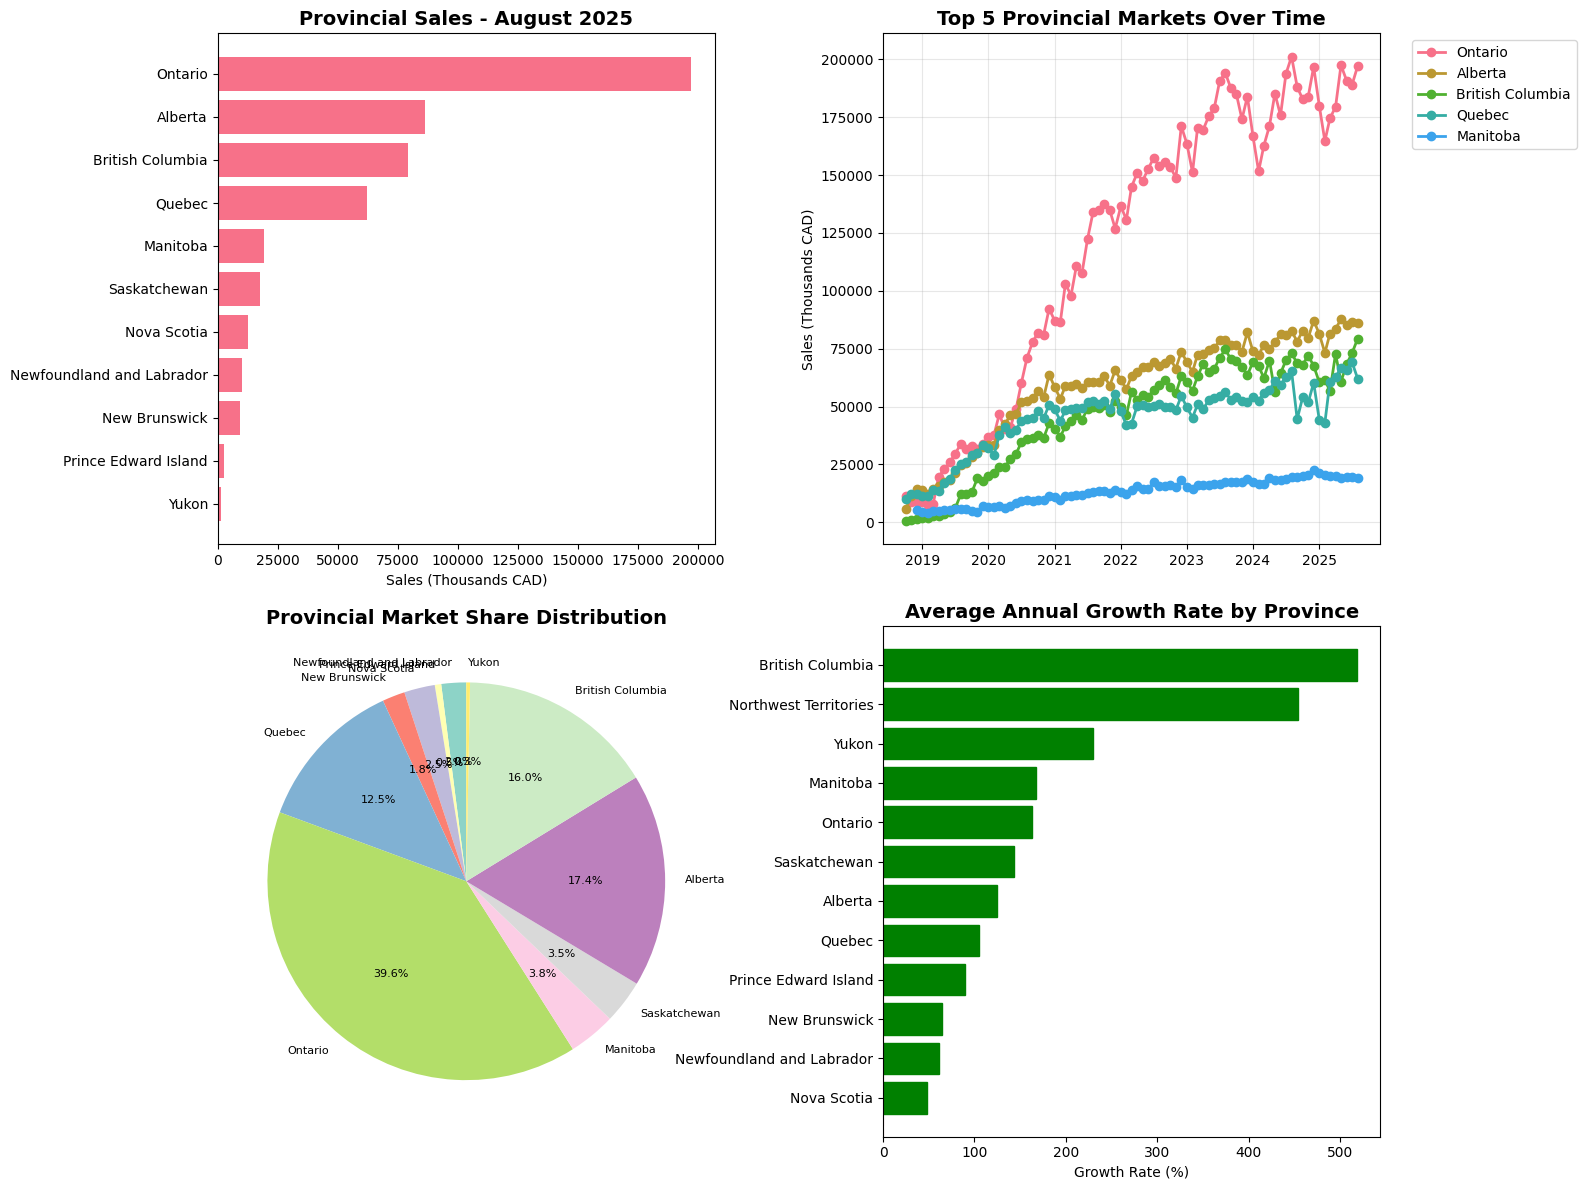


🏛️ PROVINCIAL MARKET INSIGHTS:
Market leader: Ontario
Market leader sales: $197,152,000 CAD
Top 3 provinces control 73.0% of market
Number of active provincial markets: 11
Average provincial market size: $45,209,000 CAD


In [21]:
# Provincial comparison (exclude national and cities)
provincial_data = df[df['Level'] == 'Province'].copy()

# Latest month provincial sales
latest_month = provincial_data['REF_DATE'].max()
latest_provincial = provincial_data[provincial_data['REF_DATE'] == latest_month]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Provincial market share (latest month)
latest_provincial_sorted = latest_provincial.sort_values('VALUE', ascending=True)
axes[0,0].barh(latest_provincial_sorted['GEO'], latest_provincial_sorted['VALUE'])
axes[0,0].set_title(f'Provincial Sales - {latest_month.strftime("%B %Y")}', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Sales (Thousands CAD)')

# Provincial trends over time (top 5 provinces)
top_provinces = latest_provincial.nlargest(5, 'VALUE')['GEO'].tolist()
for province in top_provinces:
    prov_data = provincial_data[provincial_data['GEO'] == province]
    axes[0,1].plot(prov_data['REF_DATE'], prov_data['VALUE'], marker='o', label=province, linewidth=2)

axes[0,1].set_title('Top 5 Provincial Markets Over Time', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('Sales (Thousands CAD)')
axes[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0,1].grid(True, alpha=0.3)

# Market concentration analysis
market_share = latest_provincial['VALUE'] / latest_provincial['VALUE'].sum() * 100
top_3_share = market_share.nlargest(3).sum()

# Create pie chart with better formatting
colors = plt.cm.Set3(np.linspace(0, 1, len(latest_provincial)))
wedges, texts, autotexts = axes[1,0].pie(market_share.values, labels=latest_provincial['GEO'], 
                                        autopct='%1.1f%%', colors=colors, startangle=90)
axes[1,0].set_title('Provincial Market Share Distribution', fontsize=14, fontweight='bold')

# Adjust text size for readability
for autotext in autotexts:
    autotext.set_fontsize(8)
for text in texts:
    text.set_fontsize(8)

# Provincial growth rates (if multi-year data available)
if provincial_data['Year'].nunique() > 1:
    growth_data = []
    for province in provincial_data['GEO'].unique():
        prov_annual = provincial_data[provincial_data['GEO'] == province].groupby('Year')['VALUE'].sum()
        if len(prov_annual) > 1:
            growth_rate = prov_annual.pct_change().mean() * 100
            growth_data.append({'Province': province, 'Growth_Rate': growth_rate})
    
    if growth_data:
        growth_df = pd.DataFrame(growth_data).sort_values('Growth_Rate', ascending=True)
        bars = axes[1,1].barh(growth_df['Province'], growth_df['Growth_Rate'])
        axes[1,1].set_title('Average Annual Growth Rate by Province', fontsize=14, fontweight='bold')
        axes[1,1].set_xlabel('Growth Rate (%)')
        axes[1,1].axvline(x=0, color='red', linestyle='--', alpha=0.5)
        
        # Color bars based on positive/negative growth
        for i, bar in enumerate(bars):
            if growth_df['Growth_Rate'].iloc[i] >= 0:
                bar.set_color('green')
            else:
                bar.set_color('red')

plt.tight_layout()
plt.show()

print(f"\n🏛️ PROVINCIAL MARKET INSIGHTS:")
print(f"Market leader: {latest_provincial.loc[latest_provincial['VALUE'].idxmax(), 'GEO']}")
print(f"Market leader sales: ${latest_provincial['VALUE'].max()*1000:,.0f} CAD")
print(f"Top 3 provinces control {top_3_share:.1f}% of market")
print(f"Number of active provincial markets: {len(latest_provincial)}")
print(f"Average provincial market size: ${latest_provincial['VALUE'].mean()*1000:,.0f} CAD")


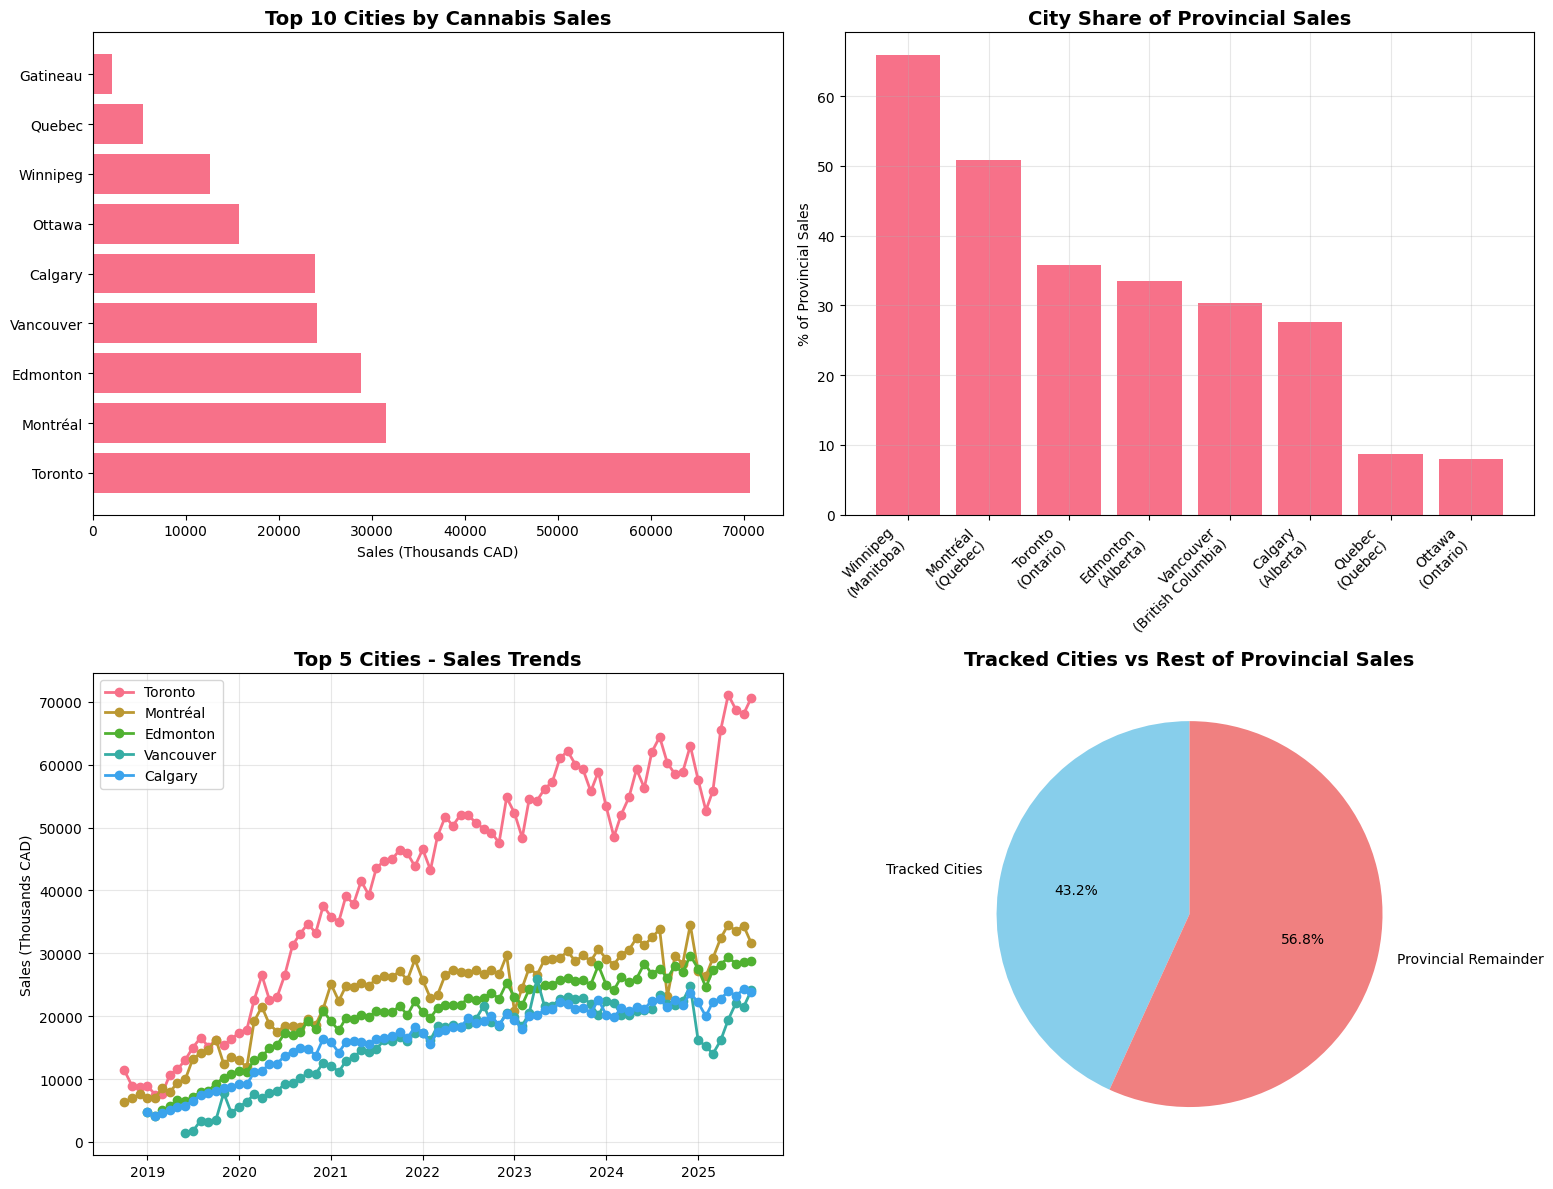


🏙️ URBAN MARKET INSIGHTS:
Leading urban market: Toronto
Leading city sales: $70,670,000 CAD
Tracked cities represent 43.2% of provincial sales
Number of tracked urban markets: 9
Average city market size: $23,865,556 CAD
Highest urban concentration: Winnipeg (65.8% of Manitoba)


In [22]:
# City-level analysis
city_data = df[df['Level'] == 'City'].copy()

if not city_data.empty:
    latest_city = city_data[city_data['REF_DATE'] == city_data['REF_DATE'].max()]
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Top cities by sales
    top_cities = latest_city.nlargest(10, 'VALUE')
    axes[0,0].barh(top_cities['City'], top_cities['VALUE'])
    axes[0,0].set_title('Top 10 Cities by Cannabis Sales', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('Sales (Thousands CAD)')
    
    # City vs Provincial comparison - corrected logic
    city_vs_province = []
    provincial_latest = df[(df['REF_DATE'] == latest_city['REF_DATE'].iloc[0]) & (df['Level'] == 'Province')]
    
    for _, city_row in latest_city.iterrows():
        province_name = city_row['Province']  # Already extracted province name
        city_sales = city_row['VALUE']
        
        # Find matching provincial data
        province_data = provincial_latest[provincial_latest['GEO'] == province_name]
        if len(province_data) > 0:
            province_sales = province_data['VALUE'].iloc[0]
            city_share = (city_sales / province_sales) * 100
            city_vs_province.append({
                'City': city_row['City'],
                'Province': province_name,
                'Share_of_Province': city_share,
                'City_Sales': city_sales,
                'Province_Sales': province_sales
            })
    
    if city_vs_province:
        city_share_df = pd.DataFrame(city_vs_province).sort_values('Share_of_Province', ascending=False)
        top_city_shares = city_share_df.head(8)
        
        bars = axes[0,1].bar(range(len(top_city_shares)), top_city_shares['Share_of_Province'])
        axes[0,1].set_title('City Share of Provincial Sales', fontsize=14, fontweight='bold')
        axes[0,1].set_ylabel('% of Provincial Sales')
        axes[0,1].set_xticks(range(len(top_city_shares)))
        axes[0,1].set_xticklabels([f"{row['City']}\n({row['Province']})" for _, row in top_city_shares.iterrows()], 
                                 rotation=45, ha='right')
        axes[0,1].grid(True, alpha=0.3)
    
    # Urban market trends - top 5 cities over time
    top_5_cities = latest_city.nlargest(5, 'VALUE')['City'].tolist()
    for city in top_5_cities:
        city_trend = city_data[city_data['City'] == city]
        axes[1,0].plot(city_trend['REF_DATE'], city_trend['VALUE'], marker='o', label=city, linewidth=2)
    
    axes[1,0].set_title('Top 5 Cities - Sales Trends', fontsize=14, fontweight='bold')
    axes[1,0].set_ylabel('Sales (Thousands CAD)')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Urban vs Provincial comparison (aggregated)
    total_city_sales = latest_city['VALUE'].sum()
    total_provincial_sales = df[(df['REF_DATE'] == latest_city['REF_DATE'].iloc[0]) & (df['Level'] == 'Province')]['VALUE'].sum()
    
    # Calculate what portion cities represent of total provincial sales
    urban_representation = (total_city_sales / total_provincial_sales) * 100
    
    # Create comparison chart
    comparison_data = ['Tracked Cities', 'Provincial Remainder']
    comparison_values = [total_city_sales, total_provincial_sales - total_city_sales]
    
    axes[1,1].pie(comparison_values, labels=comparison_data, autopct='%1.1f%%', startangle=90,
                  colors=['skyblue', 'lightcoral'])
    axes[1,1].set_title('Tracked Cities vs Rest of Provincial Sales', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n🏙️ URBAN MARKET INSIGHTS:")
    print(f"Leading urban market: {latest_city.loc[latest_city['VALUE'].idxmax(), 'City']}")
    print(f"Leading city sales: ${latest_city['VALUE'].max()*1000:,.0f} CAD")
    print(f"Tracked cities represent {urban_representation:.1f}% of provincial sales")
    print(f"Number of tracked urban markets: {len(latest_city)}")
    print(f"Average city market size: ${latest_city['VALUE'].mean()*1000:,.0f} CAD")
    
    if city_vs_province:
        highest_concentration = city_share_df.iloc[0]
        print(f"Highest urban concentration: {highest_concentration['City']} ({highest_concentration['Share_of_Province']:.1f}% of {highest_concentration['Province']})")

else:
    print("No city-level data available in the dataset.")


The first chart ("Top 10 Cities by Cannabis Sales") displays the absolute volume of sales in thousands of Canadian dollars (CAD). Toronto has the highest total sales volume in this measure.
The second chart ("City Share of Provincial Sales") displays the sales of each city as a percentage of its entire province's sales. Winnipeg accounts for a significantly larger share of Manitoba's total provincial cannabis sales than Toronto does of Ontario's total provincial cannabis sales, even though Ontario's total sales volume is much larger overall.




In [23]:
# Comprehensive statistical summary - corrected for geographic structure
print("=" * 80)
print("🍃 CANNABIS RETAIL MARKET ANALYSIS - EXECUTIVE SUMMARY")
print("=" * 80)

# Market size metrics
canada_data = df[df['Level'] == 'National']
provincial_data = df[df['Level'] == 'Province']
city_data = df[df['Level'] == 'City']

total_records = len(df)
date_range = f"{df['REF_DATE'].min().strftime('%B %Y')} to {df['REF_DATE'].max().strftime('%B %Y')}"
total_national_sales = canada_data['VALUE'].sum() * 1000

print(f"\n📊 DATASET OVERVIEW:")
print(f"Total records: {total_records:,}")
print(f"Time period: {date_range}")
print(f"National records: {len(canada_data)}")
print(f"Provincial records: {len(provincial_data)} ({provincial_data['GEO'].nunique()} provinces)")
print(f"City records: {len(city_data)} ({city_data['City'].nunique() if not city_data.empty else 0} cities)")

print(f"\n💰 MARKET SIZE:")
if not canada_data.empty:
    print(f"Cumulative national sales: ${total_national_sales:,.0f} CAD")
    print(f"Average monthly national sales: ${canada_data['VALUE'].mean()*1000:,.0f} CAD")
    print(f"Latest month sales: ${canada_data['VALUE'].iloc[-1]*1000:,.0f} CAD")
    
    # Growth metrics
    if len(canada_data) > 12:
        recent_12_months = canada_data.tail(12)['VALUE'].sum()
        previous_12_months = canada_data.iloc[-24:-12]['VALUE'].sum() if len(canada_data) >= 24 else None
        if previous_12_months and previous_12_months > 0:
            annual_growth = ((recent_12_months - previous_12_months) / previous_12_months) * 100
            print(f"12-month growth rate: {annual_growth:.1f}%")

# Market structure
print(f"\n🏛️ MARKET STRUCTURE:")
if not provincial_data.empty:
    latest_date = provincial_data['REF_DATE'].max()
    provincial_latest = provincial_data[provincial_data['REF_DATE'] == latest_date]
    
    if len(provincial_latest) > 0:
        top_3_provinces = provincial_latest.nlargest(3, 'VALUE')['GEO'].tolist()
        top_3_share = (provincial_latest.nlargest(3, 'VALUE')['VALUE'].sum() / provincial_latest['VALUE'].sum()) * 100
        
        print(f"Leading provinces: {', '.join(top_3_provinces[:3])}")
        print(f"Top 3 market share: {top_3_share:.1f}%")

if not city_data.empty:
    city_latest = city_data[city_data['REF_DATE'] == city_data['REF_DATE'].max()]
    top_cities = city_latest.nlargest(3, 'VALUE')['City'].tolist()
    print(f"Leading cities: {', '.join(top_cities[:3])}")
# Statistical insights - continued
print(f"\n📈 STATISTICAL INSIGHTS:")
if not canada_data.empty and len(canada_data) > 1:
    national_volatility = (canada_data['VALUE'].std() / canada_data['VALUE'].mean() * 100)
    print(f"National sales volatility (CV): {national_volatility:.1f}%")
    
    # Trend analysis
    if len(canada_data) >= 6:
        recent_trend = np.polyfit(range(len(canada_data.tail(6))), canada_data.tail(6)['VALUE'], 1)[0]
        trend_direction = "Growing" if recent_trend > 1000 else "Declining" if recent_trend < -1000 else "Stable"
        print(f"Recent 6-month trend: {trend_direction} ({recent_trend:.0f} CAD thousands/month)")

# Provincial statistics
if not provincial_data.empty:
    latest_provincial = provincial_data[provincial_data['REF_DATE'] == provincial_data['REF_DATE'].max()]
    if len(latest_provincial) > 1:
        provincial_volatility = (latest_provincial['VALUE'].std() / latest_provincial['VALUE'].mean() * 100)
        print(f"Inter-provincial volatility: {provincial_volatility:.1f}%")
        
        # Market concentration (Herfindahl-Hirschman Index)
        market_shares = latest_provincial['VALUE'] / latest_provincial['VALUE'].sum()
        hhi = (market_shares ** 2).sum() * 10000
        if hhi < 1500:
            concentration_level = "Competitive"
        elif hhi < 2500:
            concentration_level = "Moderately Concentrated"  
        else:
            concentration_level = "Highly Concentrated"
        print(f"Market concentration: {concentration_level} (HHI: {hhi:.0f})")

# Urban market statistics
if not city_data.empty:
    city_latest = city_data[city_data['REF_DATE'] == city_data['REF_DATE'].max()]
    print(f"Urban market diversity: {len(city_latest)} cities tracked")
    if len(city_latest) > 0:
        largest_city_share = (city_latest['VALUE'].max() / city_latest['VALUE'].sum()) * 100
        print(f"Largest city dominance: {largest_city_share:.1f}% of tracked urban sales")

# Seasonality analysis
if not canada_data.empty and canada_data['Month'].nunique() > 6:
    seasonal_cv = canada_data.groupby('Month')['VALUE'].mean().std() / canada_data.groupby('Month')['VALUE'].mean().mean() * 100
    print(f"Seasonal variation: {seasonal_cv:.1f}% coefficient of variation")
    
    peak_month = canada_data.groupby('Month')['VALUE'].mean().idxmax()
    low_month = canada_data.groupby('Month')['VALUE'].mean().idxmin()
    month_names = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
                   7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
    print(f"Peak sales month: {month_names.get(peak_month, peak_month)}")
    print(f"Lowest sales month: {month_names.get(low_month, low_month)}")

# Geographic coverage assessment
unique_provinces = df[df['Level'] == 'Province']['GEO'].nunique()
unique_cities = df[df['Level'] == 'City']['City'].nunique() if not city_data.empty else 0
print(f"Provincial coverage: {unique_provinces} provinces/territories")
print(f"Urban coverage: {unique_cities} cities")

# Market maturity indicators
print(f"\n🎯 MARKET MATURITY INDICATORS:")

if not canada_data.empty and len(canada_data) >= 12:
    # Compare early vs recent periods
    early_period = canada_data.head(6)['VALUE'].mean()
    recent_period = canada_data.tail(6)['VALUE'].mean()
    maturity_growth = ((recent_period - early_period) / early_period) * 100
    print(f"Market evolution: {maturity_growth:.1f}% growth from early to recent period")
    
    # Volatility change over time
    early_volatility = early_period_cv = (canada_data.head(len(canada_data)//2)['VALUE'].std() / 
                                         canada_data.head(len(canada_data)//2)['VALUE'].mean())
    recent_volatility = (canada_data.tail(len(canada_data)//2)['VALUE'].std() / 
                        canada_data.tail(len(canada_data)//2)['VALUE'].mean())
    volatility_change = ((recent_volatility - early_volatility) / early_volatility) * 100
    
    stability_trend = "Stabilizing" if volatility_change < -10 else "Increasing volatility" if volatility_change > 10 else "Stable volatility"
    print(f"Market stability: {stability_trend} ({volatility_change:.1f}% change in volatility)")



print("\n" + "=" * 80)
print("Analysis complete! Use the insights above to understand market dynamics,")
print("identify opportunities, and track the evolution of Canada's cannabis retail sector.")
print("=" * 80)


🍃 CANNABIS RETAIL MARKET ANALYSIS - EXECUTIVE SUMMARY

📊 DATASET OVERVIEW:
Total records: 1,801
Time period: October 2018 to August 2025
National records: 166
Provincial records: 921 (12 provinces)
City records: 714 (9 cities)

💰 MARKET SIZE:
Cumulative national sales: $53,179,099,000 CAD
Average monthly national sales: $320,356,018 CAD
Latest month sales: $468,475,000 CAD
12-month growth rate: 4.6%

🏛️ MARKET STRUCTURE:
Leading provinces: Ontario, Alberta, British Columbia
Top 3 market share: 73.0%
Leading cities: Toronto, Montréal, Edmonton

📈 STATISTICAL INSIGHTS:
National sales volatility (CV): 42.6%
Recent 6-month trend: Stable (-261 CAD thousands/month)
Inter-provincial volatility: 130.9%
Market concentration: Moderately Concentrated (HHI: 2325)
Urban market diversity: 9 cities tracked
Largest city dominance: 32.9% of tracked urban sales
Seasonal variation: 6.5% coefficient of variation
Peak sales month: Aug
Lowest sales month: Nov
Provincial coverage: 12 provinces/territories
Ur

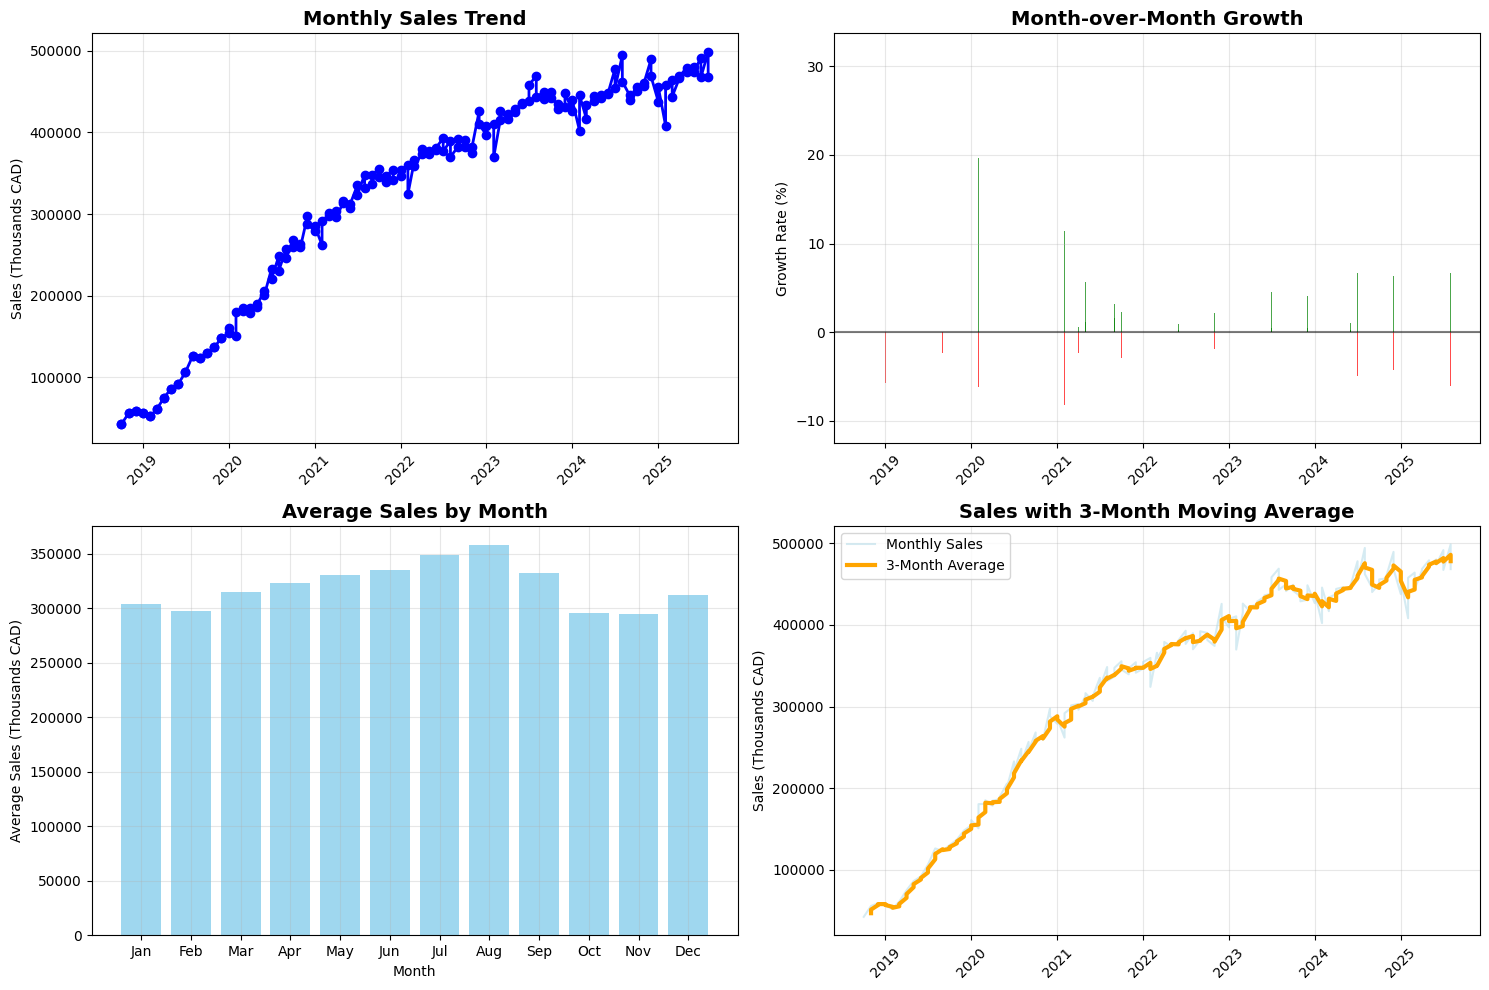

📅 MONTHLY TRENDS SUMMARY:
Latest month sales: $468,475,000 CAD
Highest sales month: August 2025 ($498,708,000)
Lowest sales month: October 2018 ($42,084,000)
Average monthly growth: 1.7%
Months with positive growth: 96/165 (58.2%)
Best performing month: Aug ($357,607,714 avg)
Weakest month: Nov ($295,118,643 avg)


In [24]:
# Simple Monthly Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

canada_data = df[df['Level'] == 'National'].copy()

if not canada_data.empty:
    canada_data = canada_data.sort_values('REF_DATE')
    
    # 1. Monthly sales over time
    axes[0,0].plot(canada_data['REF_DATE'], canada_data['VALUE'], 
                   marker='o', linewidth=2, color='blue')
    axes[0,0].set_title('Monthly Sales Trend', fontsize=14, fontweight='bold')
    axes[0,0].set_ylabel('Sales (Thousands CAD)')
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # 2. Month-over-month growth
    canada_data['MoM_Growth'] = canada_data['VALUE'].pct_change() * 100
    colors = ['green' if x >= 0 else 'red' for x in canada_data['MoM_Growth']]
    axes[0,1].bar(canada_data['REF_DATE'], canada_data['MoM_Growth'], 
                  color=colors, alpha=0.7)
    axes[0,1].set_title('Month-over-Month Growth', fontsize=14, fontweight='bold')
    axes[0,1].set_ylabel('Growth Rate (%)')
    axes[0,1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # 3. Average sales by month (seasonality)
    monthly_avg = canada_data.groupby('Month')['VALUE'].mean()
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    axes[1,0].bar(monthly_avg.index, monthly_avg.values, color='skyblue', alpha=0.8)
    axes[1,0].set_title('Average Sales by Month', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('Month')
    axes[1,0].set_ylabel('Average Sales (Thousands CAD)')
    axes[1,0].set_xticks(range(1, 13))
    axes[1,0].set_xticklabels(month_names)
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. 3-month moving average
    canada_data['MA_3'] = canada_data['VALUE'].rolling(window=3).mean()
    axes[1,1].plot(canada_data['REF_DATE'], canada_data['VALUE'], 
                   alpha=0.5, color='lightblue', label='Monthly Sales')
    axes[1,1].plot(canada_data['REF_DATE'], canada_data['MA_3'], 
                   linewidth=3, color='orange', label='3-Month Average')
    axes[1,1].set_title('Sales with 3-Month Moving Average', fontsize=14, fontweight='bold')
    axes[1,1].set_ylabel('Sales (Thousands CAD)')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Monthly insights
print("📅 MONTHLY TRENDS SUMMARY:")
print("="*40)

latest_sales = canada_data['VALUE'].iloc[-1]
highest_month = canada_data.loc[canada_data['VALUE'].idxmax(), 'REF_DATE'].strftime('%B %Y')
lowest_month = canada_data.loc[canada_data['VALUE'].idxmin(), 'REF_DATE'].strftime('%B %Y')

print(f"Latest month sales: ${latest_sales*1000:,.0f} CAD")
print(f"Highest sales month: {highest_month} (${canada_data['VALUE'].max()*1000:,.0f})")
print(f"Lowest sales month: {lowest_month} (${canada_data['VALUE'].min()*1000:,.0f})")

avg_growth = canada_data['MoM_Growth'].mean()
positive_months = (canada_data['MoM_Growth'] > 0).sum()
total_months = len(canada_data['MoM_Growth'].dropna())

print(f"Average monthly growth: {avg_growth:.1f}%")
print(f"Months with positive growth: {positive_months}/{total_months} ({positive_months/total_months*100:.1f}%)")

# Best and worst performing months
peak_season = monthly_avg.idxmax()
low_season = monthly_avg.idxmin()
print(f"Best performing month: {month_names[peak_season-1]} (${monthly_avg.iloc[peak_season-1]*1000:,.0f} avg)")
print(f"Weakest month: {month_names[low_season-1]} (${monthly_avg.iloc[low_season-1]*1000:,.0f} avg)")


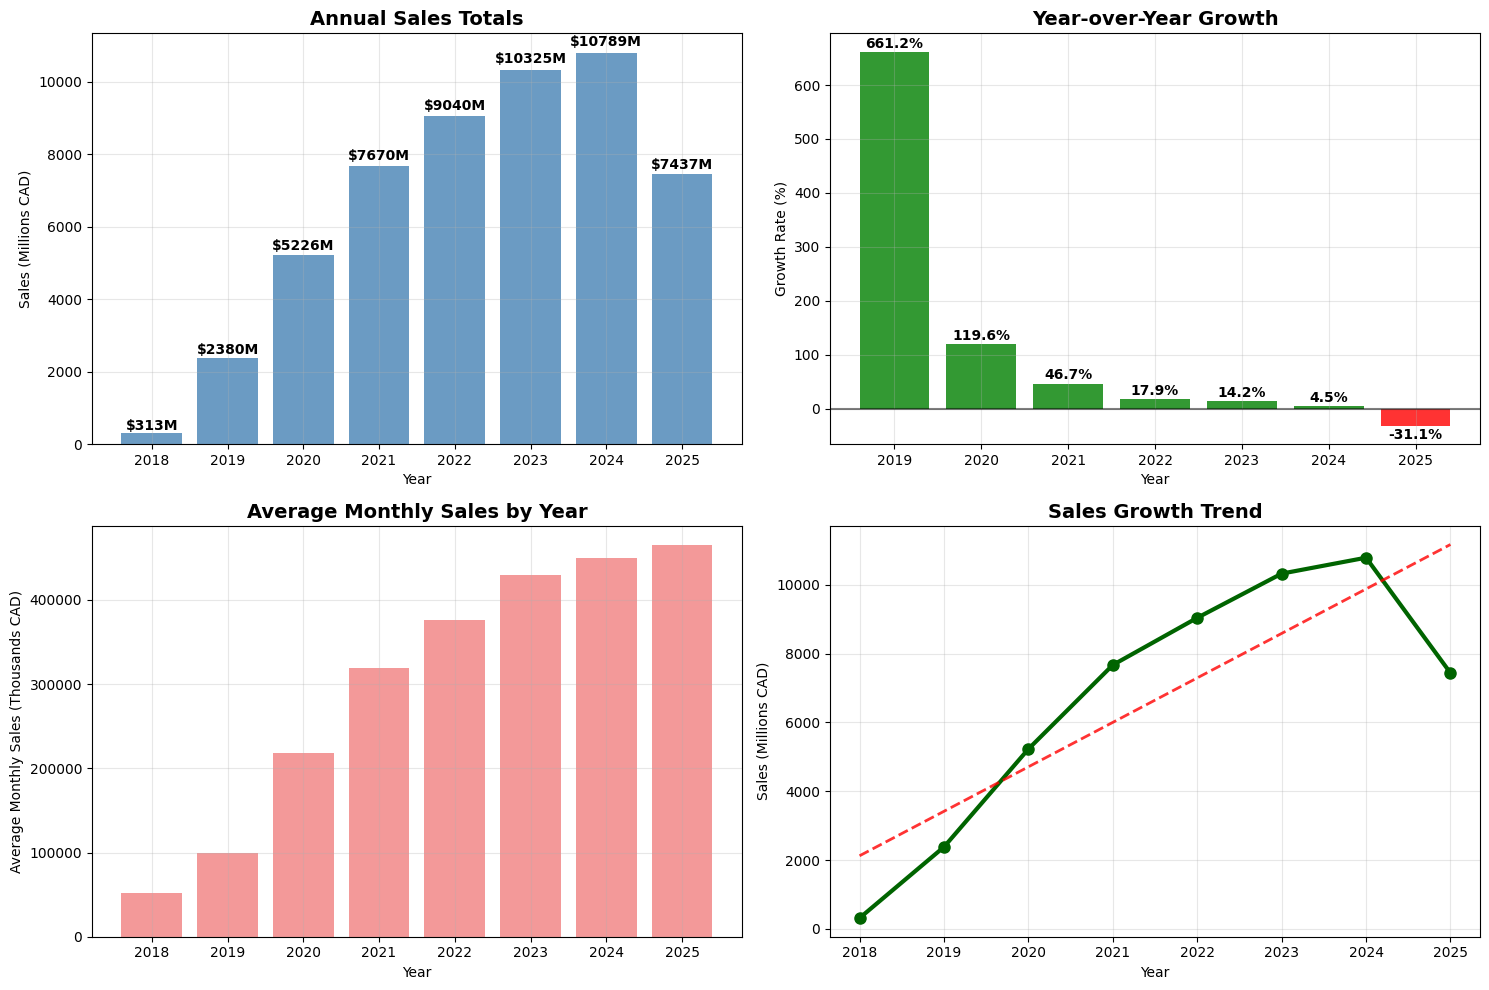


📊 YEARLY TRENDS SUMMARY:
Years covered: 2018 to 2025 (8 years)
First year sales: $313 million CAD
Latest year sales: $7437 million CAD
Total growth: 2278.6% over 7 years
Compound Annual Growth Rate (CAGR): 57.3%
Best year: 2024 ($10789M)
Weakest year: 2018 ($313M)
Years with positive growth: 6/7 (85.7%)
Average annual growth rate: 119.0%
Market classification: Large market ($10789M peak annual)


In [25]:
# Simple Yearly Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Prepare annual data
annual_data = canada_data.groupby('Year')['VALUE'].agg(['sum', 'mean', 'count']).reset_index()
annual_data['Total_Sales_Millions'] = annual_data['sum'] * 1000 / 1000000  # Convert to millions

if len(annual_data) > 0:
    # 1. Annual sales totals
    bars = axes[0,0].bar(annual_data['Year'], annual_data['Total_Sales_Millions'], 
                        color='steelblue', alpha=0.8)
    axes[0,0].set_title('Annual Sales Totals', fontsize=14, fontweight='bold')
    axes[0,0].set_ylabel('Sales (Millions CAD)')
    axes[0,0].set_xlabel('Year')
    axes[0,0].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, annual_data['Total_Sales_Millions']):
        height = bar.get_height()
        axes[0,0].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                      f'${value:.0f}M', ha='center', va='bottom', fontweight='bold')

if len(annual_data) > 1:
    # 2. Year-over-year growth
    annual_data['YoY_Growth'] = annual_data['sum'].pct_change() * 100
    colors = ['green' if x >= 0 else 'red' for x in annual_data['YoY_Growth'][1:]]
    bars = axes[0,1].bar(annual_data['Year'][1:], annual_data['YoY_Growth'][1:], 
                        color=colors, alpha=0.8)
    axes[0,1].set_title('Year-over-Year Growth', fontsize=14, fontweight='bold')
    axes[0,1].set_ylabel('Growth Rate (%)')
    axes[0,1].set_xlabel('Year')
    axes[0,1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
    axes[0,1].grid(True, alpha=0.3)
    
    # Add value labels
    for bar, value in zip(bars, annual_data['YoY_Growth'][1:]):
        if not pd.isna(value):
            height = bar.get_height()
            axes[0,1].text(bar.get_x() + bar.get_width()/2., 
                          height + (2 if height >= 0 else -4),
                          f'{value:.1f}%', ha='center', 
                          va='bottom' if height >= 0 else 'top', fontweight='bold')

    # 3. Average monthly sales by year
    axes[1,0].bar(annual_data['Year'], annual_data['mean'], color='lightcoral', alpha=0.8)
    axes[1,0].set_title('Average Monthly Sales by Year', fontsize=14, fontweight='bold')
    axes[1,0].set_ylabel('Average Monthly Sales (Thousands CAD)')
    axes[1,0].set_xlabel('Year')
    axes[1,0].grid(True, alpha=0.3)

# 4. Growth trend line
if len(annual_data) > 2:
    axes[1,1].plot(annual_data['Year'], annual_data['Total_Sales_Millions'], 
                   marker='o', linewidth=3, markersize=8, color='darkgreen')
    
    # Add trend line
    z = np.polyfit(annual_data['Year'], annual_data['Total_Sales_Millions'], 1)
    p = np.poly1d(z)
    axes[1,1].plot(annual_data['Year'], p(annual_data['Year']), 
                   "--", color='red', linewidth=2, alpha=0.8)
    
    axes[1,1].set_title('Sales Growth Trend', fontsize=14, fontweight='bold')
    axes[1,1].set_ylabel('Sales (Millions CAD)')
    axes[1,1].set_xlabel('Year')
    axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Yearly insights
print("\n📊 YEARLY TRENDS SUMMARY:")
print("="*40)

if len(annual_data) > 0:
    total_years = len(annual_data)
    first_year = annual_data['Year'].iloc[0]
    last_year = annual_data['Year'].iloc[-1]
    
    first_year_sales = annual_data['Total_Sales_Millions'].iloc[0]
    last_year_sales = annual_data['Total_Sales_Millions'].iloc[-1]
    
    print(f"Years covered: {first_year} to {last_year} ({total_years} years)")
    print(f"First year sales: ${first_year_sales:.0f} million CAD")
    print(f"Latest year sales: ${last_year_sales:.0f} million CAD")
    
    if len(annual_data) > 1:
        total_growth = ((last_year_sales - first_year_sales) / first_year_sales) * 100
        print(f"Total growth: {total_growth:.1f}% over {last_year - first_year} years")
        
        # Calculate CAGR (Compound Annual Growth Rate)
        years_span = last_year - first_year
        if years_span > 0:
            cagr = ((last_year_sales / first_year_sales) ** (1/years_span)) - 1
            print(f"Compound Annual Growth Rate (CAGR): {cagr:.1%}")
        
        # Best and worst years
        best_year = annual_data.loc[annual_data['Total_Sales_Millions'].idxmax()]
        worst_year = annual_data.loc[annual_data['Total_Sales_Millions'].idxmin()]
        
        print(f"Best year: {int(best_year['Year'])} (${best_year['Total_Sales_Millions']:.0f}M)")
        print(f"Weakest year: {int(worst_year['Year'])} (${worst_year['Total_Sales_Millions']:.0f}M)")
        
        # Growth consistency
        positive_growth_years = (annual_data['YoY_Growth'] > 0).sum()
        total_growth_years = len(annual_data['YoY_Growth'].dropna())
        
        if total_growth_years > 0:
            print(f"Years with positive growth: {positive_growth_years}/{total_growth_years} ({positive_growth_years/total_growth_years*100:.1f}%)")
        
        avg_annual_growth = annual_data['YoY_Growth'].mean()
        print(f"Average annual growth rate: {avg_annual_growth:.1f}%")

# Market size context
peak_annual_sales = annual_data['Total_Sales_Millions'].max()
if peak_annual_sales > 1000:
    market_size = "Large"
elif peak_annual_sales > 500:
    market_size = "Medium"
else:
    market_size = "Emerging"

print(f"Market classification: {market_size} market (${peak_annual_sales:.0f}M peak annual)")
